### Shark tank Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.



In [1]:

import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
# os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


# llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello Agent Ai")
result


AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BQJTdCkWOMwWEQ71w4Ncq5H3BS7H5', 'finish_reason': 'stop', 'logprobs': None}, id='run-01a47ca4-c6d2-4bfa-904e-6f56ead4d682-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image,display


In [3]:
#Graph state

class State(TypedDict):
    pitch:str
    product:str
    judge_feedback:str 
    pitch_good_or_not:str 

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade:Literal["good pitch","not good pitch"]=Field(description="Decide product pitch is good for investment by shark tank judge"),
    feedback:str=Field(
        description="If the pitch is not investable in current AI market ,provide feedback on how to make product AI marker fit"
    )

# Augment the LLM with schema for structured output

evaluator=llm.with_structured_output(Feedback)

#Nodes 

def llm_call_pitch_generator(state:State):
    """ LLM generates a pitch based on the topic"""
    if state.get("judge_feedback"):
        msg=llm.invoke(
            f"Write a investment pitch for the {state["product"]} but take into account the judge feedback:{state["feedback"]}"
        )
    else:
        msg=llm.invoke(f"Write a investment pitch about {state["product"]}")
    return {"pitch":msg.content}

#Nodes 
def llm_shark_tank_judge_pitch_evaluator(state:State):
    """LLM evaluate the pitch as a shark tank judge"""
    grade=evaluator.invoke(f"Grade the pitch {state["product"]}")
    return {"pitch_good_or_not":grade.grade,"judge_feedback":grade.feedback}


# Conditional edge function to route back to pitch generator or end based upon feedback from the evaluator

def route_pitch(state:State):
    """Route back to pitch generator or end based on upon the feedback from shark tank judge evaluator"""
    if state["pitch_good_or_not"]=="good pitch":
        return "Accepted"
    elif state["pitch_good_or_not"]=="not good pitch":
        return "Rejected +Feedback"





/Users/rahulkumar/Documents/GitHub/LLMs_Agent/Langchain_Langgraph/venv/lib/python3.12/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Decide product pitch is good for investment by shark tank judge'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


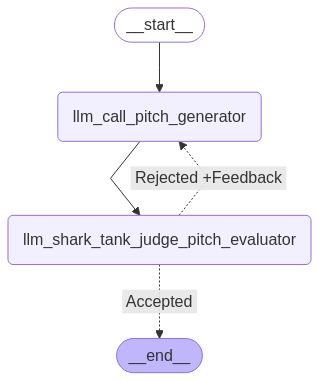

In [ ]:
#Build workflow
from langgraph.graph import StateGraph,START,END
shark_tank_builder=StateGraph(State)

#Add the nodes
shark_tank_builder.add_node("llm_call_pitch_generator",llm_call_pitch_generator)
shark_tank_builder.add_node("llm_shark_tank_judge_pitch_evaluator",llm_shark_tank_judge_pitch_evaluator)

#Add edges to connect nodes 
shark_tank_builder.add_edge(START,"llm_call_pitch_generator")
shark_tank_builder.add_edge("llm_call_pitch_generator","llm_shark_tank_judge_pitch_evaluator")

shark_tank_builder.add_conditional_edges(
    "llm_shark_tank_judge_pitch_evaluator",
    route_pitch,{
        # Name returned by route_joke:NAME OF NEXT NODE TO VISIT
        "Accepted":END,
        "Rejected +Feedback":"llm_call_pitch_generator"
    },
)

#Compile the workflow
shark_tank_workflow=shark_tank_builder.compile()

#show the workflow

display(Image(shark_tank_workflow.get_graph().draw_mermaid_png()))





In [10]:
#Invoke

state=shark_tank_workflow.invoke({"product":"AI Image generator"})
print(state["pitch"])

/Users/rahulkumar/Documents/GitHub/LLMs_Agent/Langchain_Langgraph/venv/lib/python3.12/site-packages/pydantic/json_schema.py:2324: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Decide product pitch is good for investment by shark tank judge'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


**Investment Pitch: AI Image Generator**

**Introduction:**

Ladies and gentlemen, esteemed investors, thank you for joining me today as we explore an unparalleled investment opportunity in the rapidly evolving world of artificial intelligence. I am thrilled to introduce you to our cutting-edge AI Image Generator, a transformative tool at the intersection of technology, creativity, and business, poised to redefine numerous industries and create significant economic value.

**The Market Opportunity:**

The global AI-driven image synthesis market is projected to grow exponentially over the next decade, driven by the increasing demand for high-quality visual content across various sectors. From advertising and entertainment to design and education, industries are in constant need of innovative, cost-efficient, and scalable solutions for content creation. Our AI Image Generator is designed to meet this demand, thereby capitalizing on an expanding market that is estimated to reach billions 

In [11]:
print(state["judge_feedback"])

The pitch for an AI Image Generator is generally strong, considering the high demand and versatile applications of such technology. However, to ensure it stands out and remains competitive in the rapidly advancing AI market, consider the following enhancements:

1. **Unique Selling Proposition (USP):**
   - **Personalization:** Offer unique customization features that allow users to generate images based on personal preferences or previous usage patterns.
   - **High-Quality Outputs:** Ensure the tool consistently produces high-resolution images that meet professional standards.
   - **Integration:** Provide seamless integration options with popular design software or platforms which can expand usability.

2. **Target Market and Applications:**
   - **Broaden Use Cases:** Besides art and design, promote applications in industries like marketing, advertising, digital media, and more.
   - **Educational Use:** Highlight how the tool can be used by educators and students for creative proj